In [1]:
import pandas as pd
import numpy as np
import shap

In [2]:
#make train and test datasets. Splitting labels and features happens later
path_train = "https://raw.githubusercontent.com/jvanelteren/housing/master/datasets/train.csv"
path_test = "https://raw.githubusercontent.com/jvanelteren/housing/master/datasets/test.csv"

train = pd.read_csv(path_train)
final_test = pd.read_csv(path_test)
print(train.shape, final_test.shape)
print(train.columns)

y_col = (set(train.columns) - set(final_test.columns)).pop()
train[y_col] = np.log1p(train[y_col])

# since we use cross validation the train set does not have to be split anymore
# from sklearn.model_selection import train_test_split
# train_x, test_x, train_y, test_y = train_test_split(
#     train.drop([y_col], axis=1),train.loc[:,y_col], test_size=0.33, random_state=42) 
# ds = (train_x,test_x,train_y,test_y)
# for d in ds: print(d.shape)
train_x = train.drop([y_col], axis=1)
train_y = train.loc[:,y_col]
train_x.shape, train_y.shape
import pandas_profiling as pp

(1460, 81) (1459, 80)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'Ga

In [3]:
# import aoc
# aoc.nan_inspect(train)

# import heatmap
# from heatmap import heatmap, corrplot
# from matplotlib import pyplot as plt

# plt.figure(figsize=(15, 15))
# corrplot(train.corr())

### Dataset creation

((1460, 80), (1460,))

(1460,)

### Preprocessing

In [4]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta



In [10]:
from sklearn.impute import SimpleImputer
# todo multivariate imputation, possibly with pipelines for numeric and categorical data

from sklearn.preprocessing import MinMaxScaler
# https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
# https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler/51237727
# don't know features are normal so just going with minmax scalar atm

from sklearn.preprocessing import OneHotEncoder
#https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki
#The crux of it is that the sklearn encoder creates a function which persists and can then be applied to new data sets which use the same categorical variables, with consistent results.
# So don't use pandas get dummies, but a OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

# We create the preprocessing pipelines for both numeric and categorical data.
corr = train.corr()[y_col]
corr = corr.sort_values(ascending=False)
num_x = list(corr.index)[1:]

numeric_transformer = Pipeline(steps=[
    ('impute_num', SimpleImputer(strategy='median')),
    ('scale_num', MinMaxScaler())])

cat_x = [col for col in final_test.columns if final_test[col].dtype == 'object']
cat_x.sort(key = lambda x: -correlation_ratio(train[x],train[y_col]))

categorical_transformer = Pipeline(steps=[
    ('impute_cat', SimpleImputer(strategy='most_frequent')),
    ('onehot_cat', OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, num_x),
        ('category', categorical_transformer, cat_x)])

### Modeling

In [11]:

# from catboost import CatBoostRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def inv_y(transformed_y):
    return np.exp(transformed_y)


models = [('ridge',RidgeCV()),
            ('lin',LinearRegression()),
            ('svm',svm.SVR()),
            ('lasso',LassoCV()),
            ('ElasticNet',ElasticNet()),
            ('SGDRegressor',SGDRegressor()),
            ('KNeighborsRegressor',KNeighborsRegressor()),
            ('RandomForestClassifier',RandomForestRegressor()),
            ('KernelRidge',KernelRidge()),
            # ('CatBoostRegressor',CatBoostRegressor(silent=True)),
            ('xgb.XGBRegressor',xgb.XGBRegressor()),
            # ('HistGradientBoostingRegressor',HistGradientBoostingRegressor()),
            ('MLPRegressor',MLPRegressor())
]
def get_pipeline(model):
    return Pipeline([('preprocess', preprocessor),
                   ('model',model)])

for name, model in models:
    pipe = get_pipeline(model)
    # score = -1 * cross_val_score(pipe, train_x, train_y,cv=3,scoring='neg_root_mean_squared_error')
    # below is necessary for looking at train scores
    num_fold = 3
    scores = cross_validate(pipe, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
    # scoring is identical to 
    # make_scorer(mean_squared_error,greater_is_better=False, root=False,squared=False)
    # neg_mean_squared_log_error
    print(f"{name}, \ttrain {-1 * sum(scores['train_score'])/num_fold:.3f}, test {-1 * sum(scores['test_score'])/num_fold:.3f}")


ridge, 	train 0.115, test 0.143
lin, 	train 0.089, test 0.151


KeyboardInterrupt: 

In [42]:
def submit(model):
    model = model.fit(train_x,train_y)
    pred = model.predict(final_test)
    final_test['SalePrice'] = np.exp(pred)
    final_test[['Id','SalePrice']].to_csv('submission.csv', index=False)
submit(get_pipeline(LassoCV()))

In [116]:
shap.initjs()
model = get_pipeline(xgb.XGBRegressor()).fit(train_x,train_y)
explainer = shap.TreeExplainer(model.named_steps["model"])
observations = model.named_steps["preprocess"].transform(train_x.sample(10, random_state=42))
shap_values = explainer.shap_values(observations)
all_x = num_x + list(model['preprocess'].transformers_[1][1]['onehot_cat'].get_feature_names(cat_x))

i = 0
shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations.toarray()[i], feature_names=all_x)

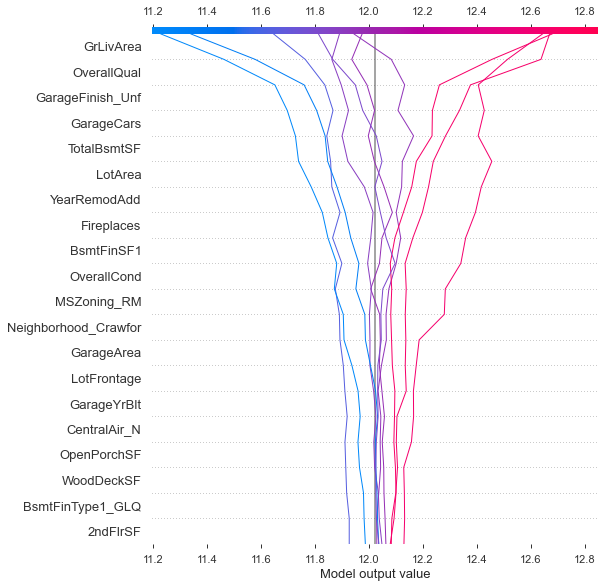

In [117]:
shap.decision_plot(explainer.expected_value, shap_values, all_x)

In [118]:
shap.force_plot(explainer.expected_value, shap_values,
                features=observations.toarray(), feature_names=all_x)

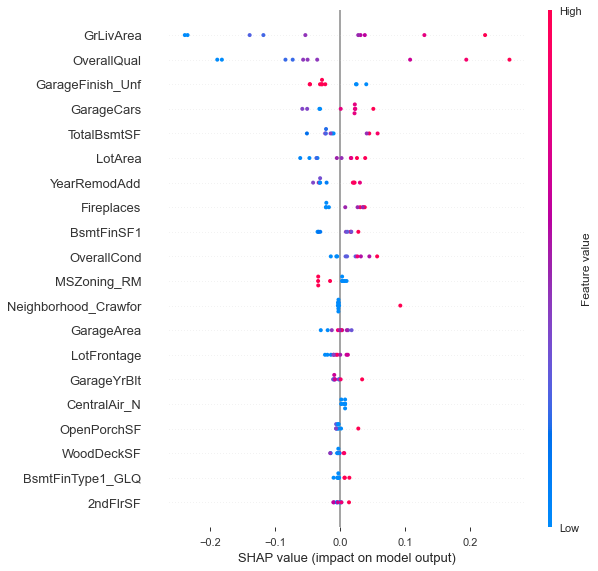

In [119]:
shap.summary_plot(shap_values, features=observations.toarray(), feature_names=all_x)

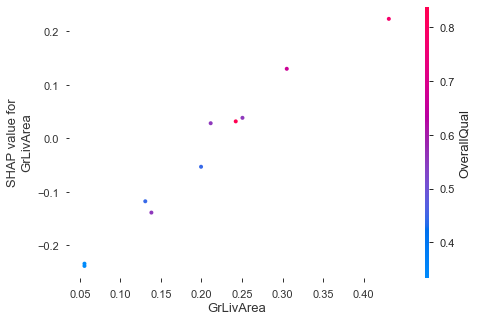

In [120]:
shap.dependence_plot("GrLivArea", shap_values, 
                     pd.DataFrame(observations.toarray(), columns=all_x))

In [37]:
model.named_steps["preprocess"].transformers

[('numeric', Pipeline(steps=[('impute_num', SimpleImputer(strategy='median')),
                  ('scale_num', MinMaxScaler())]), ['OverallQual',
   'GrLivArea',
   'GarageCars',
   'GarageArea',
   'TotalBsmtSF',
   '1stFlrSF',
   'FullBath',
   'YearBuilt',
   'YearRemodAdd',
   'GarageYrBlt',
   'TotRmsAbvGrd',
   'Fireplaces',
   'MasVnrArea',
   'BsmtFinSF1',
   'LotFrontage',
   'WoodDeckSF',
   'OpenPorchSF',
   '2ndFlrSF',
   'HalfBath',
   'LotArea',
   'BsmtFullBath',
   'BsmtUnfSF',
   'BedroomAbvGr',
   'ScreenPorch',
   'PoolArea',
   'MoSold',
   '3SsnPorch',
   'BsmtFinSF2',
   'BsmtHalfBath',
   'Id',
   'MiscVal',
   'OverallCond',
   'YrSold',
   'LowQualFinSF',
   'MSSubClass',
   'KitchenAbvGr',
   'EnclosedPorch']),
 ('category',
  Pipeline(steps=[('impute_cat', SimpleImputer(strategy='most_frequent')),
                  ('onehot_cat', OneHotEncoder(handle_unknown='ignore'))]),
  ['Neighborhood',
   'ExterQual',
   'KitchenQual',
   'BsmtQual',
   'Foundation',
   'GarageFinish',
   'HeatingQC',
   'GarageType',
   'MasVnrType',
   'BsmtFinType1',
   'Exterior1st',
   'MSZoning',
   'Exterior2nd',
   'SaleCondition',
   'CentralAir',
   'SaleType',
   'BsmtExposure',
   'HouseStyle',
   'Electrical',
   'PavedDrive',
   'LotShape',
   'BsmtCond',
   'ExterCond',
   'RoofStyle',
   'Condition1',
   'FireplaceQu',
   'GarageCond',
   'BldgType',
   'GarageQual',
   'Heating',
   'LandContour',
   'Functional',
   'LotConfig',
   'RoofMatl',
   'Condition2',
   'Fence',
   'Alley',
   'BsmtFinType2',
   'MiscFeature',
   'Street',
   'PoolQC',
   'LandSlope',
   'Utilities'])]

In [46]:
from sklearn.model_selection import GridSearchCV

hyperparameters = { 'preprocess__category__impute_cat__strategy': ['most_frequent','constant'],
                    'preprocess__numeric__impute_num__strategy': ['mean','median'],
                  }

hyperparameters = {'alpha': [1,2,3],
                    'lambda': [1,2,3]}
clf = GridSearchCV(get_pipeline(xgb.XGBRegressor()), hyperparameters, cv=2)
 
# Fit and tune model
clf.fit(train_x, train_y)

KeyError: 'base_score'

In [0]:
from altair.expr import datum
def gen_chart(name):
    return alt.Chart(url).mark_point(
        color='red',
        opacity=0.1,
        size=1
    ).encode(
        x= name+':Q',
        y='SalePrice:Q'
    ).properties(
        width=150,
        height=150
    )

#create a list of subplots
subplts = []
for name in num_x:
    subplts.append(gen_chart(name))
plots_per_row = 7
hconcat = [alt.hconcat(*subplts[i:i+plots_per_row]) for i in range(0, len(subplts), plots_per_row)]
alt.vconcat(*hconcat)

alt.VConcatChart(...)

In [0]:
brush = alt.selection(type='interval', resolve='global')

base = alt.Chart(url).mark_point(        opacity=0.1,
        size=2).encode(
    y='SalePrice:Q',
    color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray')),
).add_selection(
    brush
).properties(
    width=140,
    height=140
)
num_x.append('SalePrice')
subplts = []
for name in num_x:
    subplts.append(base.encode(x=name+':Q'))
plots_per_row = 7
hconcat = [alt.hconcat(*subplts[i:i+plots_per_row]) for i in range(0, len(subplts), plots_per_row)]
alt.vconcat(*hconcat)




alt.VConcatChart(...)

In [0]:
def gen_chart(name):
  chart = alt.Chart(url).mark_bar().encode(
        x= alt.X(name+':N', bin=False),
        y='count()',
        color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray'))
    ).properties(
        width=140,
        height=30
    ).add_selection(
    brush)

  price = alt.Chart(url).mark_boxplot().encode(
        x= alt.X(name+':N'),
        y='SalePrice:Q',
        color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray'))
    ).properties(
        width=140,
        height=140
    ).add_selection(
    brush)
  return price & chart

brush = alt.selection(type='interval', resolve='global')
#create a list of subplots
subplts = []
for name in cat_x:
    subplts.append(gen_chart(name))
plots_per_row = 7
hconcat = [alt.hconcat(*subplts[i:i+plots_per_row]) for i in range(0, len(subplts), plots_per_row)]
alt.vconcat(*hconcat)

alt.VConcatChart(...)

In [0]:
1+1

2

In [0]:
m

In [0]:
import sklearn.pipeline
from sklearn.preprocessing import Imputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))


results = []
names = []
scoring = 'accuracy'
for name, model in models:
  steps = [
    #('imputing', imp),
    (name, model)]

  pipeline = sklearn.pipeline.Pipeline(steps)

  #X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(features_train, labels_train, test_size=0.33, random_state=42)

  #fit your pipeline on X_train and y_train
  #pipeline.fit( X_train, y_train )
  #call pipeline.predict() on your X_test data to make a set of test predictions
  #y_prediction = pipeline.predict( X_test )
  #test your predictions using sklearn.classification_report()
  #report = sklearn.metrics.classification_report( y_test, y_prediction )
  #print (report)

  from sklearn import cross_validation
  kfold = KFold(len(labels_train),n_folds=20, random_state=4)
  cv_results = cross_validation.cross_val_score(pipeline,features_train, labels_train, cv=kfold,scoring=scoring)
  print (name, cv_results.mean())
  results.append(cv_results)
  names.append(name)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [0]:
!pip install catboost

In [0]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta
ratios = [(name,correlation_ratio(train[name],train[y_col])) for name in cat_x]
ratios.sort(key=lambda x: -x[1])

ratios

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

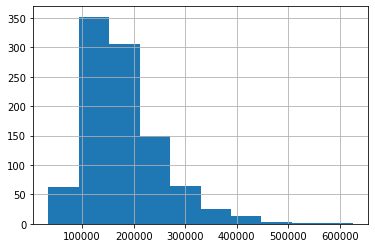